<a href="https://colab.research.google.com/github/gevargas/intergraphia/blob/main/intergraphia_wikipedia_data_harvesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wikipedia Connections: Exploring the Network Around Gabriela Mistral**


---


This notebook explores the connections of Nobel laureate Gabriela Mistral on Wikipedia by extracting and visualizing the incoming and outgoing links to her page. It then retrieves metadata for the connected individuals from Wikidata to build a network and analyse the relationships between them.

In [ ]:
!pip install wikipedia-api
!pip install wikidata
!pip install wikidata-client
!pip install requests
!pip install wikipedia
!pip install SPARQLWrapper

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=0a6f8b3d24c9b872ab234bd69ed020084890577428c89094a36f9ff6f7dd8021
  Stored in directory: /root/.cache/pip/wheels/33/3c/79/b36253689d838af4a0539782853ac3cc38a83a6591ad570dde
Successfully built wikipedia-api
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=2c16cd7660f5c680e56e1ee55a74e61179255e9adf4e8bdc827297320b54a264
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 10.7 MB/s eta 0:00:00


# **2. Collecting Gabriela Mistral's connection within her Wikipedia Page**

## 1.1 Getting Outgoing Links from Gabriela Mistral’s Wikipedia Page

- Use of wikipediaapi to fetch all outgoing links from the page "Gabriela Mistral".

Outgoing links are pages that Gabriela Mistral's article references, e.g., people she mentions.

In [ ]:
import wikipediaapi
import pandas as pd

# Initialize Wikipedia API
# Add a user_agent to identify your application
wiki = wikipediaapi.Wikipedia(language='en', extract_format=wikipediaapi.ExtractFormat.WIKI, user_agent='MyWikipediaApp/1.0')

# Load Gabriela Mistral's Wikipedia page

page = wiki.page("Gabriela Mistral")

# Collect all outgoing links (pages Gabriela's article links to)
outgoing_links = []
for title in page.links.keys():
    outgoing_links.append(title)

# Create DataFrame and tag Gabriela Mistral as the source
out_df = pd.DataFrame(outgoing_links, columns=['linked_person'])
out_df['source'] = 'Gabriela Mistral'

# Save outgoing links to CSV
out_df.to_csv('gabriela_outgoing.csv', index=False)

print("✅ Outgoing links saved. Total:", len(out_df))

✅ Outgoing links saved. Total: 424


## 1.2 Getting Incoming Links to Gabriela Mistral’s Page

- Use of the MediaWiki API (requests-based) to find all Wikipedia pages that link to "Gabriela Mistral".

In [ ]:
import requests

# Function to collect backlinks (pages linking to Gabriela Mistral)
def get_incoming_links(title, limit=500):
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "list": "backlinks",
        "bltitle": title,
        "bllimit": limit,
        "format": "json"
    }

    backlinks = []
    while True:
        response = requests.get(url, params=params).json()
        links = response.get("query", {}).get("backlinks", [])
        backlinks.extend([link["title"] for link in links])

        if 'continue' in response:
            params.update(response['continue'])
        else:
            break

    return backlinks

# Get backlinks for Gabriela Mistral
incoming_links = get_incoming_links("Gabriela Mistral")

# Create DataFrame and tag Gabriela Mistral as the target
in_df = pd.DataFrame(incoming_links, columns=["linked_person"])
in_df["target"] = "Gabriela Mistral"

# Save incoming links to CSV
in_df.to_csv("gabriela_incoming.csv", index=False)

print("✅ Incoming links saved. Total:", len(in_df))


✅ Incoming links saved. Total: 669


In [ ]:
import pandas as pd
from IPython.display import display, HTML

# Load both CSV files
df_in = pd.read_csv("gabriela_incoming.csv")
df_out = pd.read_csv("gabriela_outgoing.csv")

# Display incoming links
print("📥 People linking TO Gabriela Mistral (Incoming Links):")
display(HTML(df_in.head(10).to_html(index=False)))  # Show first 10 rows for clarity

# Display outgoing links
print("\n📤 People linked FROM Gabriela Mistral (Outgoing Links):")
display(HTML(df_out.head(10).to_html(index=False)))  # Show first 10 rows for clarity

# Optional: Show total counts
print(f"\n🔢 Total incoming links: {len(df_in)}")
print(f"🔢 Total outgoing links: {len(df_out)}")

📥 People linking TO Gabriela Mistral (Incoming Links):


linked_person,target
Albert Camus,Gabriela Mistral
Anatole France,Gabriela Mistral
André Gide,Gabriela Mistral
Aleksandr Solzhenitsyn,Gabriela Mistral
Alexander Fleming,Gabriela Mistral
April 7,Gabriela Mistral
Bertrand Russell,Gabriela Mistral
Boris Pasternak,Gabriela Mistral
Chile,Gabriela Mistral
Czesław Miłosz,Gabriela Mistral



📤 People linked FROM Gabriela Mistral (Outgoing Links):


linked_person,source
1901 Nobel Prize in Literature,Gabriela Mistral
1902 Nobel Prize in Literature,Gabriela Mistral
1903 Nobel Prize in Literature,Gabriela Mistral
1904 Nobel Prize in Literature,Gabriela Mistral
1905 Nobel Prize in Literature,Gabriela Mistral
1906 Nobel Prize in Literature,Gabriela Mistral
1907 Nobel Prize in Literature,Gabriela Mistral
1908 Nobel Prize in Literature,Gabriela Mistral
1909 Nobel Prize in Literature,Gabriela Mistral
1910 Nobel Prize in Literature,Gabriela Mistral



🔢 Total incoming links: 669
🔢 Total outgoing links: 424


# **2. Cleaning the collected raw data and preparing a dataset**

## 2.1 Cleaning and Standardising in and out coming links CSV Files
 Data cleaning ensures both files are consistent and ready to be merged or used in graph construction.

In [ ]:
import re

# A simple regex to detect if a string likely contains a full name
def is_probably_person(name):
    return bool(re.match(r'^[A-Z][a-z]+(?:\s+[A-Z][a-z]+)+$', name.strip()))

# Initialize clean dataframes with original data
df_in_clean = df_in.copy()
df_out_clean = df_out.copy()

# Filter rows with probable person names only
df_in_clean = df_in_clean[df_in_clean["target"].apply(is_probably_person)]
df_in_clean = df_in_clean[df_in_clean["linked_person"].apply(is_probably_person)]

df_out_clean = df_out_clean[df_out_clean["source"].apply(is_probably_person)]
df_out_clean = df_out_clean[df_out_clean["linked_person"].apply(is_probably_person)]

# Show samples after filtering
print("✅ Filtered Incoming Links:")
display(df_in_clean.head())

print("✅ Filtered Outgoing Links:")
display(df_out_clean.head())

✅ Filtered Incoming Links:


,linked_person,target
0,Albert Camus,Gabriela Mistral
1,Anatole France,Gabriela Mistral
3,Aleksandr Solzhenitsyn,Gabriela Mistral
4,Alexander Fleming,Gabriela Mistral
6,Bertrand Russell,Gabriela Mistral


✅ Filtered Outgoing Links:


,linked_person,source
125,Abdulrazak Gurnah,Gabriela Mistral
126,Albert Camus,Gabriela Mistral
127,Alejandra Quintana Arocho,Gabriela Mistral
128,Aleksandr Solzhenitsyn,Gabriela Mistral
129,Alexander Fleming,Gabriela Mistral


## 2.2 Building an integrated dataset: merging incoming and outgoing links

Do the union of the cleaned incoming (df_in_clean) and outgoing (df_out_clean) links into a single DataFrame, representing Gabriela Mistral's immediate connections.


To analyze the complete network of mentions (who links to whom), we need a unified dataset. Some links may be incoming for one person and outgoing for another, but in the graph, both are just edges between nodes.

In [ ]:
# Combine both filtered dataframes into one unified edge list
combined_links = pd.concat([df_in_clean, df_out_clean], ignore_index=True)

# Drop duplicates, if any
combined_links.drop_duplicates(inplace=True)

# Preview the combined data
print(f"✅ Combined edge list has {combined_links.shape[0]} links between people.")
display(combined_links.head(10))


✅ Combined edge list has 329 links between people.


,linked_person,target,source
0,Albert Camus,Gabriela Mistral,NaN
1,Anatole France,Gabriela Mistral,NaN
2,Aleksandr Solzhenitsyn,Gabriela Mistral,NaN
3,Alexander Fleming,Gabriela Mistral,NaN
4,Bertrand Russell,Gabriela Mistral,NaN
5,Boris Pasternak,Gabriela Mistral,NaN
6,Derek Walcott,Gabriela Mistral,NaN
7,Ernest Hemingway,Gabriela Mistral,NaN
8,Elias Canetti,Gabriela Mistral,NaN
9,George Bernard Shaw,Gabriela Mistral,NaN


## 2.3 Filtering unique people

This code block extracts all unique names from the 'linked_person' and 'target' columns of the combined_links DataFrame. It then creates a new DataFrame called people_df containing these unique names in a sorted list and prints the total number of unique people found.

In [ ]:
import pandas as pd

# Assuming combined_links is your full graph edge DataFrame
# Extract from both source and target (some columns might be NaN)
linked_people = combined_links['linked_person'].dropna().unique()
target_people = combined_links['target'].dropna().unique()

# Combine both into a set of unique nodes
unique_people = set(linked_people).union(set(target_people))

# Create DataFrame to show
people_df = pd.DataFrame({'Person': sorted(unique_people)})

# Show how many unique people we got
print(f"✅ Total unique people (nodes): {len(people_df)}")

# Display the table
people_df.head(10)  # or just people_df to view all

✅ Total unique people (nodes): 232


,Person
0,Abdulrazak Gurnah
1,Albert Camus
2,Alberto Baeza Flores
3,Alejandra Costamagna
4,Alejandra Quintana Arocho
5,Aleksandr Solzhenitsyn
6,Alexander Fleming
7,Alfonsina Storni
8,Alice Munro
9,Alicia Morel


## 2.4 Extracting Unique People
This code extracts unique names from the 'linked_person' and 'target' columns of the combined_links DataFrame, combines them, and then prints the total count of unique individuals found.

In [ ]:
import pandas as pd

# Assume combined_links is your full edge DataFrame
linked_people = combined_links['linked_person'].dropna().unique()
target_people = combined_links['target'].dropna().unique()

# Combine and deduplicate
unique_people = sorted(set(linked_people) | set(target_people))
print(f"✅ Total unique people found: {len(unique_people)}")


✅ Total unique people found: 232


## 2.5 Completing the dataset with complementary data about Gabriela Mistral's connections

Definition of a function fetch_people_metadata that (1) queries Wikidata for metadata (birth/death dates, description, occupation, nationality, gender) for a batch of people's names.
2. It then iterates through the unique_people list in batches, calls the function to get the data for each batch, and appends the results to the all_data list.
3. It includes error handling and delays to manage potential timeouts and rate limits from the SPARQL endpoint.

In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON
import time
from tqdm import tqdm

def fetch_people_metadata(names_batch):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

    filter_names = ' '.join(f'"{name}"@en' for name in names_batch)

    query = f"""
    SELECT ?personLabel ?birth_date ?death_date ?description ?occupationLabel ?nationalityLabel ?genderLabel WHERE {{
      VALUES ?personLabel {{ {filter_names} }}
      ?person rdfs:label ?personLabel.
      OPTIONAL {{ ?person wdt:P569 ?birth_date. }}
      OPTIONAL {{ ?person wdt:P570 ?death_date. }}
      OPTIONAL {{ ?person schema:description ?description. FILTER (lang(?description) = "en") }}
      OPTIONAL {{ ?person wdt:P106 ?occupation. }}
      OPTIONAL {{ ?person wdt:P27 ?nationality. }}
      OPTIONAL {{ ?person wdt:P21 ?gender. }}
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    """

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    # Retry in case of timeout
    for attempt in range(3):
        try:
            results = sparql.query().convert()
            return results["results"]["bindings"]
        except Exception as e:
            print(f"⏳ Attempt {attempt + 1} failed: {e}")
            time.sleep(5) # Wait longer before retrying
    return []

all_data = []
batch_size = 20

for i in tqdm(range(0, len(unique_people), batch_size)):
    batch = unique_people[i:i + batch_size]
    batch_results = fetch_people_metadata(batch)

    for result in batch_results:
        all_data.append({
            "name": result.get("personLabel", {}).get("value"),
            "birth_date": result.get("birth_date", {}).get("value"),
            "death_date": result.get("death_date", {}).get("value"),
            "description": result.get("description", {}).get("value"),
            "occupation": result.get("occupationLabel", {}).get("value"),
            "nationality": result.get("nationalityLabel", {}).get("value"),
            "gender": result.get("genderLabel", {}).get("value"),
        })
    time.sleep(10) # Add a longer delay between batches to avoid rate limiting

100%|██████████| 12/12 [02:06<00:00, 10.55s/it]


#**3. Interactive data cleaning (human in the loop)**

## 3.1 Creating and interactive cleaning process
1. Set up an interactive tool using ipywidgets to clean the collected person attributes data.
2. Load a CSV file, add 'Exclude' and 'Status' columns if they don't exist, and display the data in an interactive table.

Users can select a row, update its 'Status' and 'Exclude' values using dropdowns and a checkbox, and save the cleaned data to a new CSV file.

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Load your preliminary dataset (make sure columns include name/Status)
df = pd.read_csv("data_cleaning/person_attributes.csv")

# Add column for user exclusion if not present
if "Exclude" not in df.columns:
    df["Exclude"] = False

if "Status" not in df.columns:
    df["Status"] = "person"  # default value

# Output widget
output = widgets.Output()

def create_table():
    with output:
        output.clear_output()
        display(df)

create_table()

# Widgets for row selection and status update
row_selector = widgets.Dropdown(options=list(df.index), description="Row:")
status_selector = widgets.Dropdown(options=["person", "unknown"], description="Status:")
exclude_checkbox = widgets.Checkbox(value=False, description="Exclude?")

def on_update(_):
    idx = row_selector.value
    df.at[idx, "Status"] = status_selector.value
    df.at[idx, "Exclude"] = exclude_checkbox.value
    create_table()

update_btn = widgets.Button(description="Update Row", button_style="info")
update_btn.on_click(on_update)

# Save cleaned dataset
def on_save(_):
    cleaned = df[df["Exclude"] == False]
    cleaned.to_csv("data_cleaning/cleaned_person_attributes.csv", index=False)
    print("✅ Cleaned file saved as data_cleaning/cleaned_person_attributes.csv")
    display(cleaned.head())

save_btn = widgets.Button(description="Save Cleaned File", button_style="success")
save_btn.on_click(on_save)

# Display the interactive UI
display(widgets.VBox([
    widgets.HTML("<h3>Interactive Cleaning Tool</h3>"),
    widgets.HBox([row_selector, status_selector, exclude_checkbox, update_btn]),
    save_btn,
    output
]))


## 3.2 Showing the cleaned dataset (i.e., DataFrame)

In [ ]:
people_df = pd.DataFrame(all_data)
print(f"✅ Metadata collected for {len(people_df)} people")

# Display some rows
people_df.head(40)


✅ Metadata collected for 2228 people


,name,birth_date,death_date,description,occupation,nationality,gender
0,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),screenwriter,United States,male
1,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),photographer,United States,male
2,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),writer,United States,male
3,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),teacher,United States,male
4,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),poet,United States,male
5,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),playwright,United States,male
6,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),musician,United States,male
7,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),autobiographer,United States,male
8,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),diarist,United States,male
9,Aleksandr Solzhenitsyn,1918-12-11T00:00:00Z,2008-08-03T00:00:00Z,"Russian writer, publicist, poet and politician...",screenwriter,Russia,male


# **4. Building datasets representing Gabriela Mistral's connections' community**

## 4.1 Extract Female People and Save as CSV
N.B. Make sure this runs after you have already built full_people_df

In [ ]:
# Print unique values in the 'gender' column of people_df for debugging
print("Unique values in people_df['gender']:", people_df['gender'].unique())

# Filter for female individuals
female_df = people_df[people_df['gender'] == 'female'].copy() # Use label 'female'

# Check if female_df is empty
if female_df.empty:
    print("❌ No female individuals found with the specified gender label.")
else:
    # Optional: Reset index and sort by name
    # Ensure 'Person' column exists before sorting
    if 'Person' in female_df.columns:
        female_df = female_df.sort_values('Person').reset_index(drop=True)
    else:
        print("❌ 'Person' column not found in female_df. Cannot sort.")


    # Save to CSV
    female_df.to_csv("female_people.csv", index=False)

    # Confirm result
    print(f"✅ Total female people found: {len(female_df)}")
    display(female_df.head(20))  # Show first 10 rows

Unique values in people_df['gender']: ['male' 'female' None]
❌ 'Person' column not found in female_df. Cannot sort.
✅ Total female people found: 284


,name,birth_date,death_date,description,occupation,nationality,gender
88,Alice Munro,1931-07-10T00:00:00Z,2024-05-13T00:00:00Z,Canadian writer (1931–2024),screenwriter,Canada,female
89,Alice Munro,1931-07-10T00:00:00Z,2024-05-13T00:00:00Z,Canadian writer (1931–2024),writer,Canada,female
90,Alice Munro,1931-07-10T00:00:00Z,2024-05-13T00:00:00Z,Canadian writer (1931–2024),journalist,Canada,female
91,Alice Munro,1931-07-10T00:00:00Z,2024-05-13T00:00:00Z,Canadian writer (1931–2024),novelist,Canada,female
92,Alice Munro,1931-07-10T00:00:00Z,2024-05-13T00:00:00Z,Canadian writer (1931–2024),short story writer,Canada,female
93,Alfonsina Storni,1892-05-29T00:00:00Z,1938-10-25T00:00:00Z,Argentine writer,writer,Argentina,female
94,Alfonsina Storni,1892-05-29T00:00:00Z,1938-10-25T00:00:00Z,Argentine writer,teacher,Argentina,female
95,Alfonsina Storni,1892-05-29T00:00:00Z,1938-10-25T00:00:00Z,Argentine writer,poet,Argentina,female
96,Alfonsina Storni,1892-05-29T00:00:00Z,1938-10-25T00:00:00Z,Argentine writer,journalist,Argentina,female
97,Alfonsina Storni,1892-05-29T00:00:00Z,1938-10-25T00:00:00Z,Argentine writer,sociologist,Argentina,female


## 4.2 Extract Male People and Save as CSV

Filter gender == 'male' and save as male_people.csv.

In [ ]:
male_df = people_df[people_df['gender'] == 'male'].copy()
male_df = male_df.sort_values('name').reset_index(drop=True)
male_df.to_csv("male_people.csv", index=False)
print(f"✅ Total male people found: {len(male_df)}")
male_df.head(10)

✅ Total male people found: 1229


,name,birth_date,death_date,description,occupation,nationality,gender
0,Abdulrazak Gurnah,1948-12-20T00:00:00Z,None,Tanzanian novelist and academic,writer,United Kingdom,male
1,Abdulrazak Gurnah,1948-12-20T00:00:00Z,None,Tanzanian novelist and academic,prose writer,Tanzania,male
2,Abdulrazak Gurnah,1948-12-20T00:00:00Z,None,Tanzanian novelist and academic,novelist,Tanzania,male
3,Abdulrazak Gurnah,1948-12-20T00:00:00Z,None,Tanzanian novelist and academic,university teacher,Tanzania,male
4,Abdulrazak Gurnah,1948-12-20T00:00:00Z,None,Tanzanian novelist and academic,editing staff,Tanzania,male
5,Abdulrazak Gurnah,1948-12-20T00:00:00Z,None,Tanzanian novelist and academic,editing staff,United Kingdom,male
6,Abdulrazak Gurnah,1948-12-20T00:00:00Z,None,Tanzanian novelist and academic,prose writer,United Kingdom,male
7,Abdulrazak Gurnah,1948-12-20T00:00:00Z,None,Tanzanian novelist and academic,novelist,United Kingdom,male
8,Abdulrazak Gurnah,1948-12-20T00:00:00Z,None,Tanzanian novelist and academic,university teacher,United Kingdom,male
9,Abdulrazak Gurnah,1948-12-20T00:00:00Z,None,Tanzanian novelist and academic,writer,Tanzania,male


## 4.3 Provide a quantitative study of the dataset

1. Gender distribution
2. Nationality breakdown
3. Most common occupations
4. Birth year distribution

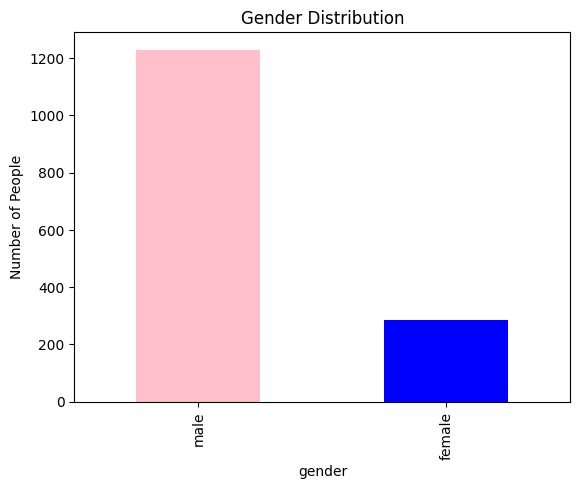

In [ ]:
import matplotlib.pyplot as plt

# Simple gender count
gender_counts = people_df['gender'].value_counts()
gender_counts.plot(kind='bar', title='Gender Distribution', color=['pink', 'blue'])
plt.ylabel('Number of People')
plt.show()



---



# **5. Preparing data for building Gabriela Mistral's connection graph**

In [ ]:
# Save all people
people_df.to_csv("all_people.csv", index=False)

# Save edge list (if not already saved)
combined_links.to_csv("edges.csv", index=False)

## 5.1 Harvesting nodes properties from Wikidata

Defining a Python function fetch_people_metadata that takes a list of names as input. It constructs a SPARQL query to retrieve the birth date, death date, and label for each person from Wikidata. It then sends this query to the Wikidata SPARQL endpoint and retrieves the results in JSON format. The function includes a retry mechanism in case of query timeouts.

In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON
import time

def fetch_people_metadata(names_batch):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

    filter_names = ' '.join(f'"{name}"@en' for name in names_batch)

    query = f"""
    SELECT ?personLabel ?birth_date ?death_date WHERE {{
      VALUES ?personLabel {{ {filter_names} }}
      ?person rdfs:label ?personLabel.
      OPTIONAL {{ ?person wdt:P569 ?birth_date. }}
      OPTIONAL {{ ?person wdt:P570 ?death_date. }}
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    """

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    # Retry in case of timeout
    for attempt in range(3):
        try:
            results = sparql.query().convert()
            return results["results"]["bindings"]
        except Exception as e:
            print(f"⏳ Attempt {attempt + 1} failed: {e}")
            time.sleep(2)
    return []

This code block extracts unique names from the 'linked_person' and 'target' columns of the combined_links DataFrame, combines them, and then prints the total count of unique individuals found.

In [ ]:
import pandas as pd

# Assume combined_links is your full edge DataFrame
linked_people = combined_links['linked_person'].dropna().unique()
target_people = combined_links['target'].dropna().unique()

# Combine and deduplicate
unique_people = sorted(set(linked_people) | set(target_people))
print(f"✅ Total unique people found: {len(unique_people)}")

✅ Total unique people found: 232


## 5.2 Creating and visualising Gabriela Mistral's connections as a graph

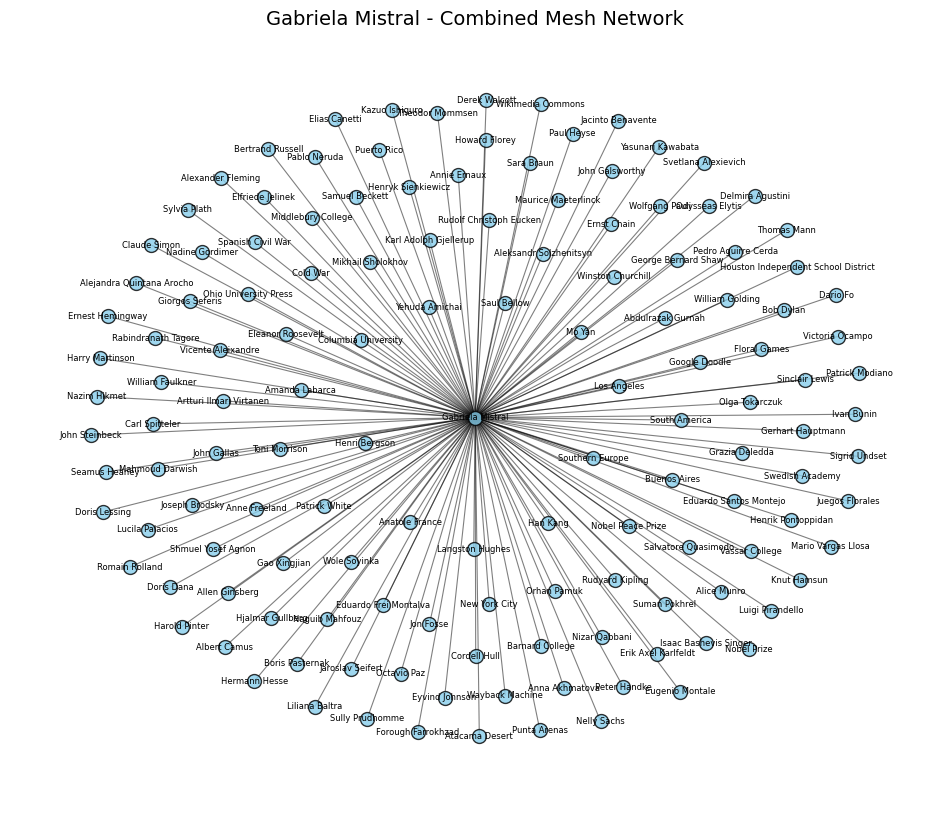

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the combined dataset
# Replace 'gabriela_mistral_all.csv' with your actual file path
df = pd.read_csv('edges.csv')

# Ensure columns exist (e.g., 'Source' and 'Target')
# Adjust column names based on your dataset
source_col = 'source'
target_col = 'linked_person'

# Create the graph
G = nx.Graph()

# Add edges from the DataFrame
for _, row in df.iterrows():
    # Handle cases where either source or target might be missing (NaN)
    source_node = row[source_col]
    target_node = row[target_col]

    if pd.notna(source_node) and pd.notna(target_node):
         G.add_edge(source_node, target_node)


# Draw the mesh network
plt.figure(figsize=(12, 10)) # Increased figure size for better visibility
pos = nx.spring_layout(G, seed=42, k=0.5)  # Layout for mesh style, adjusted k for spacing
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue', alpha=0.8, edgecolors='black') # Decreased node size
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.5) # Decreased edge width
nx.draw_networkx_labels(G, pos, font_size=6) # Decreased font size

plt.title("Gabriela Mistral - Combined Mesh Network", fontsize=14) # Simplified title
plt.axis('off')
plt.show()

## 5.3 Creating and visualising Gabriela Mistral's connections as a **property** graph

In [ ]:
!pip install pyvis pandas networkx

import pandas as pd
import networkx as nx
from pyvis.network import Network
from IPython.display import display, HTML

# === 1. Load your dataset ===
# Replace with your actual combined CSV of male + female people
df = pd.read_csv("all_people.csv")

# === 2. Create Graph with properties ===
G = nx.Graph()

for _, row in df.iterrows():
    G.add_node(row['name'],
               birthday=row.get('birthday', None),
               deathday=row.get('deathday', None),
               birth_place=row.get('birth_place', None),
               death_place=row.get('death_place', None),
               nationality=row.get('nationality', None),
               occupation=row.get('occupation', None),
               wikisite=row.get('wikisite', None))

# Example relationship building (replace with your real edge list)
for nationality in df['nationality'].dropna().unique():
    people_same_nat = df[df['nationality'] == nationality]['name'].tolist()
    for i in range(len(people_same_nat)):
        for j in range(i+1, len(people_same_nat)):
            G.add_edge(people_same_nat[i], people_same_nat[j])

# === 3. Gabriela Mistral Subgraph Stats ===
if "Gabriela Mistral" in G.nodes:
    gm_neighbors = list(nx.neighbors(G, "Gabriela Mistral"))
    gm_subgraph = G.subgraph([ "Gabriela Mistral" ] + gm_neighbors)
    print("Gabriela Mistral Graph Stats:")
    print(f"Nodes: {gm_subgraph.number_of_nodes()}")
    print(f"Edges: {gm_subgraph.number_of_edges()}")
else:
    print("Gabriela Mistral not found in dataset.")

# === 4. Build Interactive PyVis Graph ===
net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")

for node, data in G.nodes(data=True):
    title_info = "<br>".join([f"{k}: {v}" for k, v in data.items() if v is not None])
    net.add_node(node, title=title_info, label=node)

for source, target in G.edges():
    net.add_edge(source, target)

# Save & show inline in Colab
net.save_graph("people_network.html")
display(HTML("people_network.html"))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.1 MB/s eta 0:00:00
Gabriela Mistral Graph Stats:
Nodes: 29
Edges: 428


# **6. Miscellaneous - looking up Wikipedia biographies**

In [ ]:
page = wiki.page("Gabriela Mistral")


In [ ]:
 page.exists():
    if "may refer to" in page.summary[:50]:  # simple checkif
        print("⚠️ This page is a disambiguation. Need manual verification.")


In [ ]:
# Using Wikidata client
from wikidata.client import Client
client = Client()
gabriela = client.get('Q236198', load=True)
